# Unsupervised Deep learning for Foreground Segmentation Exploiting Low-rank and Sparse Priors

# import pytorch and fix seed

In [ ]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())
    torch.cuda.empty_cache()
import random
import numpy as np
def torch_fix_seed(seed=1):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(seed=2)

Tesla T4
157797376
12585009152


In [ ]:
#@title some functions for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from torchvision.utils import make_grid

def anim_make(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def anim_make_for_UNet(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[0]):
        V = []
        for l in range(len(MM)):
            # print(MM[l][i].shape, MM[l].shape)
            V.append(MM[l][i])
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def make_and_plot_grid(data, nrows=16):
    fig = plt.figure(figsize=(nrows*2,8))
    data = torch.tensor(data).unsqueeze(1)
    grid = make_grid(data).permute(1,2,0)
    plt.imshow(grid)


def plot_loss(historyr):
    plt.rcParams["font.size"] = 16
    fig = plt.figure()
    plt.plot(list(loss_hist['total'].values()), label='Total loss')
    plt.plot(list(loss_hist['nuclear'].values()), label='Nuclear norm')
    plt.plot(list(loss_hist['l1'].values()), label='L1 norm')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [ ]:
#@title ## Download and extract data zipfile
import zipfile
import os

root_dir = "/tmp/hall"
if not os.path.isdir(root_dir):
    !wget --no-check-certificate --show-progress -q\
        "https://www.dropbox.com/s/hof9g5af1964j8r/hall.zip?dl=1" \
        -O "/tmp/hall.zip"
    
    zip_filename = "/tmp/hall.zip"
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(root_dir)
    zip_ref.close()

imageseq_files = sorted(os.listdir(root_dir))

from PIL import Image
import numpy as np

im = np.array(Image.open(root_dir + '/' + imageseq_files[0]))
imageseq = []
for filename in imageseq_files:
    fullname = root_dir + '/' + filename
    if os.path.isfile(fullname):
        imageseq.append(np.array(Image.open(fullname)))

imageseq = np.array(imageseq)
print(imageseq.shape)


(3584, 144, 176, 3)


# Randomly select training data and prepare test data.
- n_frames(int): Number of training images
- training_index(tuple of int): This indicates indices of frames used as training set. When you set 'None', randomly chosen from all frames.
- test_target_index(int): Index of target frame used as test set
- number_of_test_images(int): Number of test images. default: n_frames

In [ ]:
n_frames = 16
training_index = None
target_index = 1926
number_of_test_images = n_frames

In [ ]:
#@title plot training set
import torchvision
if training_index==None:
    training_index = np.random.permutation(len(imageseq))[:n_frames]
print("training index:",np.sort(training_index))
DDseq = imageseq[training_index].copy().astype(float) / 255.
print(DDseq.shape)
DD = DDseq.reshape(n_frames,imageseq.shape[1]*imageseq.shape[2], 3)

print(DD.shape)
print(DD.min(), DD.max())

m, n, _ = DD.shape
# make_and_plot_grid(torch.tensor(DDseq))

res = torchvision.transforms.Resize([512,512])
DDseq = torch.stack(list(map(res, (torch.tensor(DDseq).permute(0,-1,1,2)))))
print(DDseq.shape)
# make_and_plot_grid(DDseq)

training index: [  18  505  520  549 1606 1720 1854 1868 2064 2216 2303 2550 2959 3320
 3333 3473]
(16, 144, 176, 3)
(16, 25344, 3)
0.0 1.0
torch.Size([16, 3, 512, 512])


In [ ]:
DDseq = DDseq.unsqueeze(1).repeat(1,3,1,1)

RuntimeError: ignored

In [ ]:
#@title plot test set
D_test = imageseq[target_index-number_of_test_images:target_index,:,:].copy().astype(float) / 255.
DD_test = torch.tensor(D_test.reshape(D_test.shape[0], imageseq.shape[1]*imageseq.shape[2]).T).float().cuda()
make_and_plot_grid(D_test)

ValueError: ignored

In [ ]:
DD_test = res(torch.tensor(DD_test))
print(DD_test.shape)
make_and_plot_grid(DD_test)

NameError: ignored

In [ ]:
DD_test = DD_test.unsqueeze(1).repeat(1,3,1,1)

# Try our unsupervised deep learning approach!
![](https://github.com/tsakailab/DeepLS/blob/main/model_architecture.png?raw=1)

In [ ]:
#@title initialize our model
!pip install transformers
from transformers import SegformerForSemanticSegmentation
# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=3,
                                                        #  id2label=id2label, 
                                                        #  label2id=label2id,
).cuda()
# print(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.classifier.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_

In [ ]:
#@title implemention of the computation of two norms $\|L\|_*,\|S\|_1$ used for loss function
Nuclear_norm = lambda x: torch.sum(torch.svd(x)[1])
L1_norm = lambda x: torch.sum(torch.abs(x))

In [ ]:
#@title hyperparameter setting
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lambda_loss = 1/np.sqrt(512*512)
# lambda_loss = 1/np.sqrt(128*128)
# lambda_loss = 0

In [ ]:
crip = torchvision.transforms.Resize([128,128])

100%|██████████| 5/5 [00:05<00:00,  1.04s/it, loss=786, nuclear_norm=716, L1_norm=70.5]


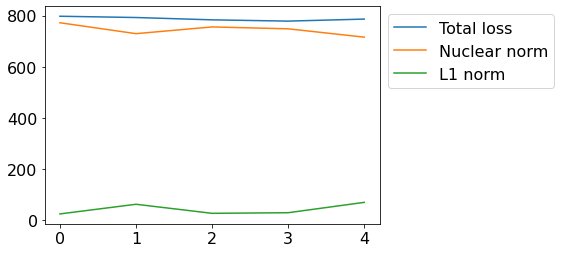

In [ ]:
#@title run training (about 3~4 min for 50 training images with 500 epochs)
from tqdm import tqdm
from collections import OrderedDict

# prepare training data
DD_UNet = DDseq.float().cuda()

history_loss_Unet = []
loss_hist = {}
loss_hist['total'] = {}
loss_hist['l1'] = {}
loss_hist['nuclear'] = {}

bar = tqdm(total = num_epochs, position=0, leave=True)
for iter in range(num_epochs):
    total_loss = 0.

    # predict foreground
    S = model(DD_UNet)["logits"]
    
    # construct matrices
    S_mat = S.reshape(DD_UNet.shape[0], -1)
    L_mat = ((crip(DD_UNet)-S).view(crip(DD_UNet).shape[0], -1))

    # compute loss
    nloss = Nuclear_norm(L_mat)
    lloss = L1_norm(S_mat)*lambda_loss
    loss = nloss + lloss

    # optimize model parameter
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    history_loss_Unet.append(total_loss)
    bar.set_postfix(OrderedDict(loss=total_loss, nuclear_norm=nloss.item(), L1_norm=lloss.item()))
    loss_hist['total'][iter] = loss.item()
    loss_hist['l1'][iter] = lloss.item()
    loss_hist['nuclear'][iter] = nloss.item()
    bar.update(1)
bar.close()
### Results
plot_loss(loss_hist)
model = model.eval()

In [ ]:
#@title output of our model (lambda = 1/512, epoch=5)
D_UNet = crip(DD_UNet).cpu()                                        # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)     # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)            # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (lambda = 1/512, epoch=25)
D_UNet = crip(DD_UNet).cpu()                                        # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)     # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)            # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (lambda = 1/512, epoch=50)
D_UNet = crip(DD_UNet).cpu()                                        # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)     # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)            # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (lambda = 1/512, epoch=100)
D_UNet = crip(DD_UNet).cpu()                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (lambda = 1/512, epoch=300)
D_UNet = crip(DD_UNet).cpu()                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (lambda = 1/128)
D_UNet = crip(DD_UNet).cpu()                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (crip(D_UNet)-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet.permute(0, 2, 3, 1),  L_UNet.permute(0, 2, 3, 1),  S_UNet.permute(0, 2, 3, 1)  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (for train set)
D_UNet = DD_UNet.cpu()[:, 0]                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet)["logits"].detach().cpu()   # S=UNet(D) :(batch size, image height, image width)
    S_UNet = torch.nn.functional.interpolate(S_UNet, size=512, mode="bilinear", align_corners=False).squeeze(1)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of our model (for test sequence)
D_UNet = torch.tensor(D_test).cpu().squeeze(1)                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(torch.tensor(D_test).float().cuda().unsqueeze(1)).detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)                  # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

# Run RPCA for comparison
RPCA can derive from the alternating directions method of multipliers the following iteration steps.
\begin{align}
L &\gets& \textrm{svt}(D-S-U, 1/\rho)\tag{1}\\
S &\gets& \textrm{soft}(D-L-U, \lambda/\rho)\tag{2}\\
U &\gets& U+L+S-D\tag{3}
\end{align}
Here, $\rho$ is an arbitrary positive constant.
The singular value thresholding operation, denoted as $\textrm{svt}$ in Eq.(1),
of a matrix $Q$ with a threshold $\tau\geq 0$ is defined as
\begin{equation}
 \textrm{svt}(Q,\tau)= U\textrm{soft}( K,\tau) V^\top\tag{4}
\end{equation}
where the matrices $ U$, $ K$ and $ V$ are the singular value decomposition (SVD)
of $ Q= U K V^\top$.
The soft thresholding operation,
denoted as $\textrm{soft}$ in Eqs. (2) and (4),
is defined as
$$
 \textrm{soft}(q,\tau)=\textrm{sign}(q)\max(|q|-\tau,0),
$$

[ 50/500]: loss = 924.3152,  
[100/500]: loss = 921.9452,  
[150/500]: loss = 921.3690,  
[200/500]: loss = 921.1520,  
[250/500]: loss = 921.0728,  
[300/500]: loss = 921.0513,  
[350/500]: loss = 921.0349,  
[400/500]: loss = 921.0312,  
[450/500]: loss = 921.0300,  
[500/500]: loss = 921.0260,  
6124.800682067871  [ms]


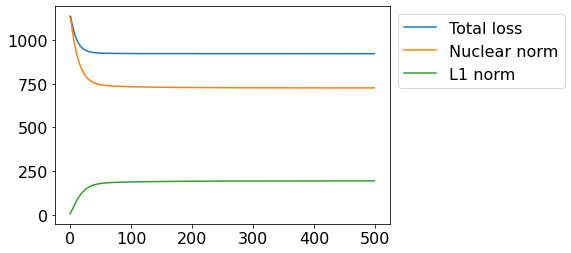

In [ ]:
#@title RPCA (for comparison)
### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

def svt(input, th):
    u, s, v = torch.svd(input)
    return torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,th))), torch.transpose(v, -2, -1)), u, s, v


### Algorithm
from time import time
D = torch.from_numpy(DD.astype(np.float32)).to(device).clone()
# D = torch.rand((79,256*256)).to(device).clone()

# Hyperparameters
rcp_rho = 1./ 1.
m, n = D.shape[0], D.shape[1]
ls = 1./np.sqrt(max(m,n))


# Using L1Loss with prox
# nucloss =lambda x:  torch.sum(torch.linalg.svdvals(x))
nucloss =lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x))


S, U  = 0, 0
t = time()
num_iter = 500
display_step = num_iter // 10
loss_hist = {}
loss_hist['total'] = {}
loss_hist['l1'] = {}
loss_hist['nuclear'] = {}

for iter in range(num_iter):
    with torch.no_grad():
        L = svt(D - S - U, rcp_rho)[0]
        S = soft(D - L - U, ls*rcp_rho)
        U = U + L + S - D
        objJ = nucloss(L) + ls * l1loss(S)
        loss_hist['total'][iter] = objJ.item()
        loss_hist['l1'][iter] = ls * l1loss(S).item()
        loss_hist['nuclear'][iter] = nucloss(L).item()

    # history_loss.append(objJ.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, objJ))
fin = (time()-t)*1000
print(fin, ' [ms]')
### Results
plot_loss(loss_hist)

In [ ]:
#@title Output of RPCA (for train set)
DLDiffanim = anim_make([  D.detach().cpu(),  L.detach().cpu(),  S.detach().cpu()  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title vector rejection and vector projection
u, s, v = torch.svd((L))
vector_projection = torch.matmul(u, torch.matmul(u.T, DD_test)).detach().cpu()
vector_rejection = (DD_test - vector_projection.cuda()).detach().cpu()
DLDiffanim = anim_make([  DD_test.detach().cpu(),  vector_projection,  vector_rejection  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

# Let's change camera geometry!
Our model is robust for changes in camera geometry while slight realistic change in camera geometry could violate for RPCA.
As a simple example, we have provided an example of enlarging test data.

In [ ]:
from torchvision import transforms

## 1.2x zoom
scale = 1.2
changes_in_camera_geometry = torch.nn.Sequential(
    transforms.Resize((int(144*scale), int(176*scale))),
    transforms.CenterCrop((144, 176)),
)

In [ ]:
# Apply change in camera geometry to test sequence
changed_D_test = changes_in_camera_geometry(torch.tensor(D_test))
changed_DD_test = changed_D_test.reshape(changed_D_test.shape[0], -1).T.float().cuda()

In [ ]:
#@title output of ours
D_UNet = changed_D_test.cpu().squeeze(1)
with torch.no_grad():
    S_UNet = model(changed_D_test.float().cuda().unsqueeze(1)).detach().cpu().squeeze(1)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)
DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

In [ ]:
#@title output of RPCA
u, s, v = torch.svd((L))
vector_projection = torch.matmul(u, torch.matmul(u.T, changed_DD_test)).detach().cpu()
vector_rejection = (changed_DD_test - vector_projection.cuda()).detach().cpu()
DLDiffanim = anim_make([  changed_DD_test.detach().cpu(),  vector_projection,  vector_rejection  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())